<a href="https://colab.research.google.com/github/makaires77/Grafos-2021/blob/main/P5b_PPGIA_Bipartite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p> <img src="https://drive.google.com/uc?export=view&id=14ecpPr37UaWMNtZYQ3TgLyvYO6Wgh-qA" align="right" width="200px"> </p>

# Atividade 5 - Análise Coautoria de Pesquisas PPGIA<br>
AIRES, Marcos. CARUBBI, Ricardo. SIQUEIRA, Fernando. Alunos de Análise de Dados em Grafos.<br>
Professor orientador: Prof. Dr. Raimir Holanda.<br>
Programa de Pós-Graduação em Informática Aplicada. Universidade de Fortaleza - UNIFOR.




## Objetivo

O objetivo desta versão do trabalho é realizar as análises e cortes restrito ao grafo dos professores do PPGIA e respectivos trabalhos publicados.

## Configurações

In [1]:
# Endereço da base de dados
local = '/content/drive/MyDrive/Colab Notebooks/GRAFOS/P3/'

# Configuração de plotagem
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({
    'figure.figsize': (25, 15),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

# Fixação do seed
from numpy import random as nprand
seed = 200
nprand.seed(seed)

# Importação dos módulos do NetworkX
import networkx as nx
from networkx import bipartite
from networkx import NetworkXError
from networkx import edge_betweenness_centrality
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.centrality import girvan_newman

#Importação dos módulos de suporte
import re, random, itertools, copy
from numpy import random as nprand
import pandas as pd

# ignoring warnings
import warnings
warnings.simplefilter("ignore")

## Carregar o Grafo a partir do arquivo CSV.

Código do aluno Marcos Aires para tratamento e limpeza dos dados.

In [2]:
_autor_union = pd.read_csv(local + 'lst_autorunion.csv', sep=';')
_autorias    = pd.read_csv(local + 'ppgia_coautoria-bipartite.csv',sep=';')
autorias        = pd.DataFrame(_autorias)
lst_autor       = sorted(set(autorias['AUTORES'].unique()))

print('Quantidade de Autores Antes: ',len(lst_autor))

for n in range(len(autorias['AUTORES'])):
    rem_acentos = autorias['AUTORES'][n].replace("\'","").replace("De ", "de ").replace("Das ","das ").replace("Da ","da ").replace("Do ","do ").replace("Dos ","dos ").replace("Á","A").replace("á","a").replace("â","a").replace("ã","a").replace("à","a").replace("é","e").replace("ê","e").replace("'è","e").replace("í","i").replace("ó","o").replace("ô","o").replace("ú","u")
    autorias['AUTORES'][n]=rem_acentos.replace("\"","").strip()

    for m in range(len(_autor_union)):
        n1=str(autorias['AUTORES'][n]).strip()
        n2=str(_autor_union['NomeDe'][m]).replace('\'','').strip()
#         print(n1, n2)
        if n1 == n2:
#             print(' Alteração de:',n2)
            corrigido=str(_autor_union['NomePara'][m]).replace("\'","").strip()
            autorias['AUTORES'][n]=corrigido.replace("\"","").strip()
#             print('Alterado para:',autorias['AUTORES'][n])

# print(sorted(set(autorias['AUTORES'].unique())))

autorias.to_csv(local + 'ppgia_coautorias.csv', sep=";", index=False)
lst_autor  = sorted(set(autorias['AUTORES'].unique()))
print('-'*90)
print('Quantidade de Autores Depois:',len(lst_autor))

Quantidade de Autores Antes:  984
------------------------------------------------------------------------------------------
Quantidade de Autores Depois: 828


In [3]:
# Criação do grafo não direcionado vazio
B = nx.Graph()

# Professores do PPGIA
PPGIA = ['Placido Rogerio Pinheiro','Adriano Bessa Albuquerque','Americo Tadeu Falcone Sampaio','Joao Batista Furlan Duarte',
               'Joao Jose Vasco Peixoto Furtado','Maria Andreia Formico Rodrigues','Maria Elizabeth Sucupira Furtado',
               'Nabor das Chagas Mendonça','Napoleao Vieira Nepomuceno','Raimir Holanda Filho','Tarcisio Haroldo Cavalcante Pequeno',
               'Vladia Celia Monteiro Pinheiro']

# Carregamento dos dados no grafo
with open(local + 'ppgia_coautorias.csv') as f:
    
    for row in f:
        # Definição dos nós
        linha = row.strip().split(";")
        artigo = linha[1]
        autor = linha[2]
        if autor in PPGIA: # Restrição PPGIA
            B.add_edge(autor, artigo)
            # Definição dos atributos dos nós
            B.nodes[autor]["bipartite"] = 0
            B.nodes[artigo]["bipartite"] = 1

## Representar os dados como um Grafo Bipartido entre os trabalhos publicados e os autores dos trabalhos.

> "Um grafo bipartido é um grafo cujos nós podem ser dividos em dois conjuntos distintos U e V, nos quais cada link (aresta) conecta um nó U a uma nó V."<br>

Barabási, Albert-László ; Pósfai, Márton: Network science. Cambridge : Cambridge University Press, 2016.<br>

> "Seja G = (V,E) um grafo. Se o conjunto de vértices V de G puder ser
particionado em dois subconjuntos não vazios, X e Y (X ∪ Y = V e X ∩ Y =
∅) de tal maneira que cada aresta de G tenha uma extremidade em X e a outra em Y, então G é chamado de bipartido. A partição V = X ∪ Y é chamada de
bipartição de G."

Nicoletti, Maria do Carmo. Fundamentos da teoria dos grafos para computação / Maria do Carmo Nicoletti, Estevam R. Hruschka Jr. - 3. ed. - Rio de Janeiro : LTC, 2018.

> "Um grafo bipartido é aquele que pode ter seus vértices divididos em dois conjuntos ou partições tais que nelas não se encontrem vizinhos. Em caso da existência de k conjuntos de vértices disjuntos, o grafo é dito k-partido."<br>

Goldbarg, Marco Cesar. Grafos : conceitos, algoritmos e aplicações / Marco Goldbarg, Elizabeth Goldbarg. - Rio de Janeiro : Elsevier, 2012.

In [4]:
# Considerando apenas componentes concectados
B = B.subgraph(list(nx.connected_components(B))[0])

# Renomea os labels dos nós como inteiros sequenciais e atribuir o nome completo como atributo
B = nx.relabel.convert_node_labels_to_integers(B, first_label=0, ordering='increasing degree', label_attribute='name')

In [5]:
# Gera e define o atributo 'bipartite' para identificação dos grupos de autores e artigos
autores = [v for v in B.nodes if B.nodes[v]["bipartite"] == 0]
artigos = [v for v in B.nodes if B.nodes[v]["bipartite"] == 1]

In [6]:
# Identifica os nós pelo label e pelo atributo 'name'.
[(f'node {x}',B.nodes[x]['name']) for x in autores]

[('node 315', 'Placido Rogerio Pinheiro'),
 ('node 313', 'Maria Elizabeth Sucupira Furtado'),
 ('node 314', 'Joao Jose Vasco Peixoto Furtado'),
 ('node 312', 'Maria Andreia Formico Rodrigues'),
 ('node 308', 'Nabor das Chagas Mendonça'),
 ('node 309', 'Raimir Holanda Filho'),
 ('node 310', 'Joao Batista Furlan Duarte'),
 ('node 307', 'Vladia Celia Monteiro Pinheiro'),
 ('node 304', 'Americo Tadeu Falcone Sampaio'),
 ('node 311', 'Adriano Bessa Albuquerque'),
 ('node 306', 'Napoleao Vieira Nepomuceno'),
 ('node 305', 'Tarcisio Haroldo Cavalcante Pequeno')]

In [7]:
# Identifica o número de autores e artigos
print('Número de autores do PPGIA:', len(autores))
print('Número de trabalhos publicados:', len(artigos))

Número de autores do PPGIA: 12
Número de trabalhos publicados: 304


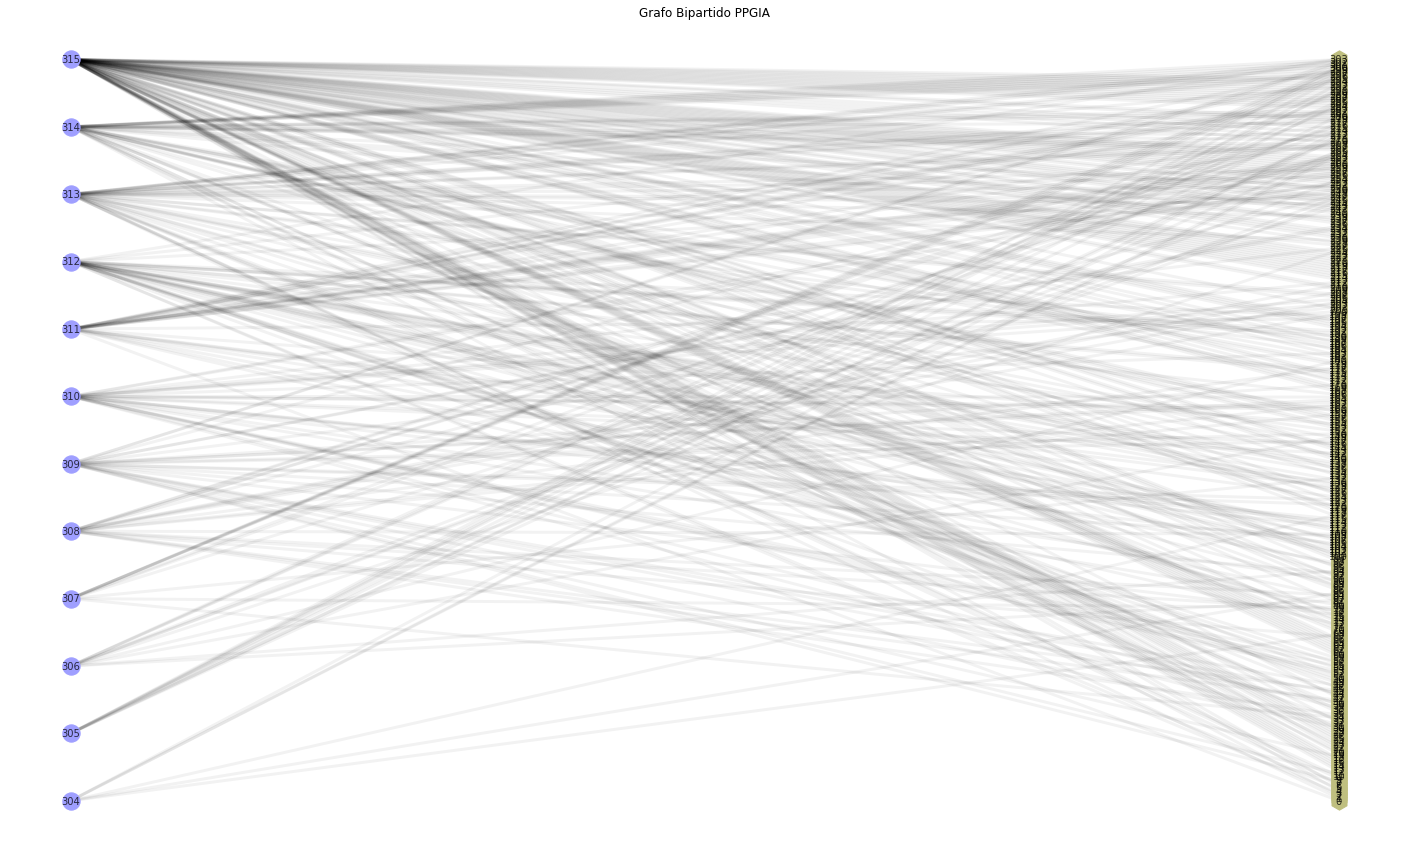

In [8]:
#@title
# Create figure
plt.figure(figsize=(25,15))
plt.title('Grafo Bipartido PPGIA')
# Calculate layout
pos = nx.bipartite_layout(B, autores)
# Draw using different shapes and colors for autores/titulos
nx.draw_networkx_edges(B, pos, width=3, alpha=0.05)
nx.draw_networkx_nodes(B, pos, nodelist=artigos, node_color="#bfbf7f", node_shape="h", node_size=300)
nx.draw_networkx_nodes(B, pos, nodelist=autores, node_color="#9f9fff", node_size=300)
nx.draw_networkx_labels(B, pos, alpha=.75, font_size=10)
plt.savefig(local + 'GRAFO_P3b-1.png', dpi=150)

Pode-se identificar pelo grafo bipartido o grau de cada nó representado pelo respectivo número de arestas, identificando os professores do PPGIA com maior número de trabalhos publicados.

In [9]:
# Identificação de professores ordenados pelo número de trabalhos publicados
full_name_B = nx.get_node_attributes(B, "name")
[(f'node {x}', full_name_B[x], B.degree[x]) for x in sorted(autores, key=lambda x:B.degree[x], reverse=True)]
# [(x, B.degree[x]) for x in sorted(autores, key=lambda x:B.degree[x], reverse=True)]

[('node 315', 'Placido Rogerio Pinheiro', 123),
 ('node 314', 'Joao Jose Vasco Peixoto Furtado', 42),
 ('node 313', 'Maria Elizabeth Sucupira Furtado', 40),
 ('node 312', 'Maria Andreia Formico Rodrigues', 36),
 ('node 311', 'Adriano Bessa Albuquerque', 28),
 ('node 310', 'Joao Batista Furlan Duarte', 25),
 ('node 309', 'Raimir Holanda Filho', 23),
 ('node 308', 'Nabor das Chagas Mendonça', 19),
 ('node 307', 'Vladia Celia Monteiro Pinheiro', 11),
 ('node 306', 'Napoleao Vieira Nepomuceno', 11),
 ('node 305', 'Tarcisio Haroldo Cavalcante Pequeno', 9),
 ('node 304', 'Americo Tadeu Falcone Sampaio', 6)]

## Gerar um Grafo Monopartido ponderado com apenas os autores.

> Um grafo monopartido U (ou projeção de U) é obtido pela conexão entre dois nós U que compartilham o mesmo nó V na representação bipartida de U". Pode-se definir duas projeções para um grafo bipartido, respectivamente uma projeção de U em V e de V em U.

Barabási, Albert-László ; Pósfai, Márton: Network science. Cambridge : Cambridge University Press, 2016.

### Grafo Monopartido Ponderado dos Professores do PPGIA

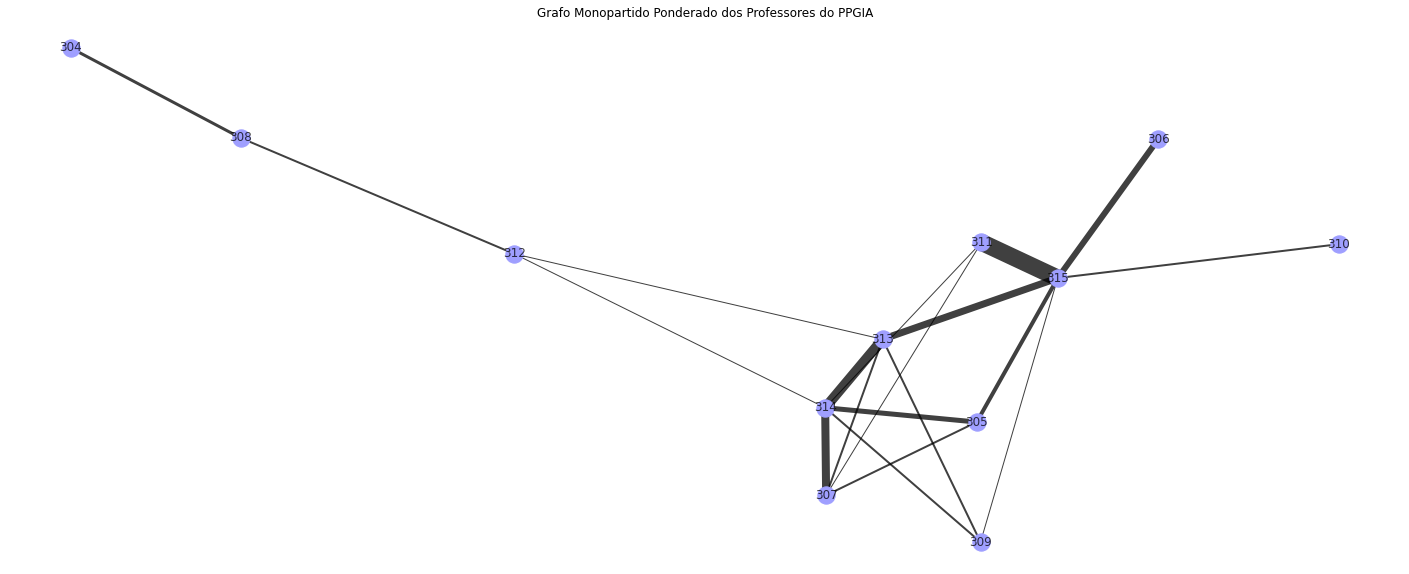

In [10]:
#@title
# Gera o grafo monopartido
G = bipartite.weighted_projected_graph(B, autores)

# Gera o grafo monopartido usando o index Jaccard.
# O índice Jaccard é o número de vizinhos comuns para dois nós dividido pelo 
# número de nós vizinhos a qualquer um dos nós. Este índice varia de 0 (não 
# vizinhos comuns) a 1 (todos os vizinhos são em comum).
# G = bipartite.overlap_weighted_projected_graph(B, autores) # Jaccard index

# Create figure
plt.figure(figsize=(25,10))
plt.title('Grafo Monopartido Ponderado dos Professores do PPGIA')
# Get weights
weight = [G.edges[e]['weight'] for e in G.edges]
# Calculate layout
pos = nx.spring_layout(G, weight='weight', k=0.5)
# Draw edges, nodes, and labels
nx.draw_networkx_edges(G, pos, width=weight, alpha=0.75)
nx.draw_networkx_nodes(G, pos, node_color="#9f9fff", node_size=300)
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels, font_size=8, alpha=.5)
nx.draw_networkx_labels(G, pos, alpha=.75)
plt.savefig(local + 'GRAFO_P3b-2.png', dpi=150)

### Grafo Monopartido dos Trabalhos Publicados do PPGIA

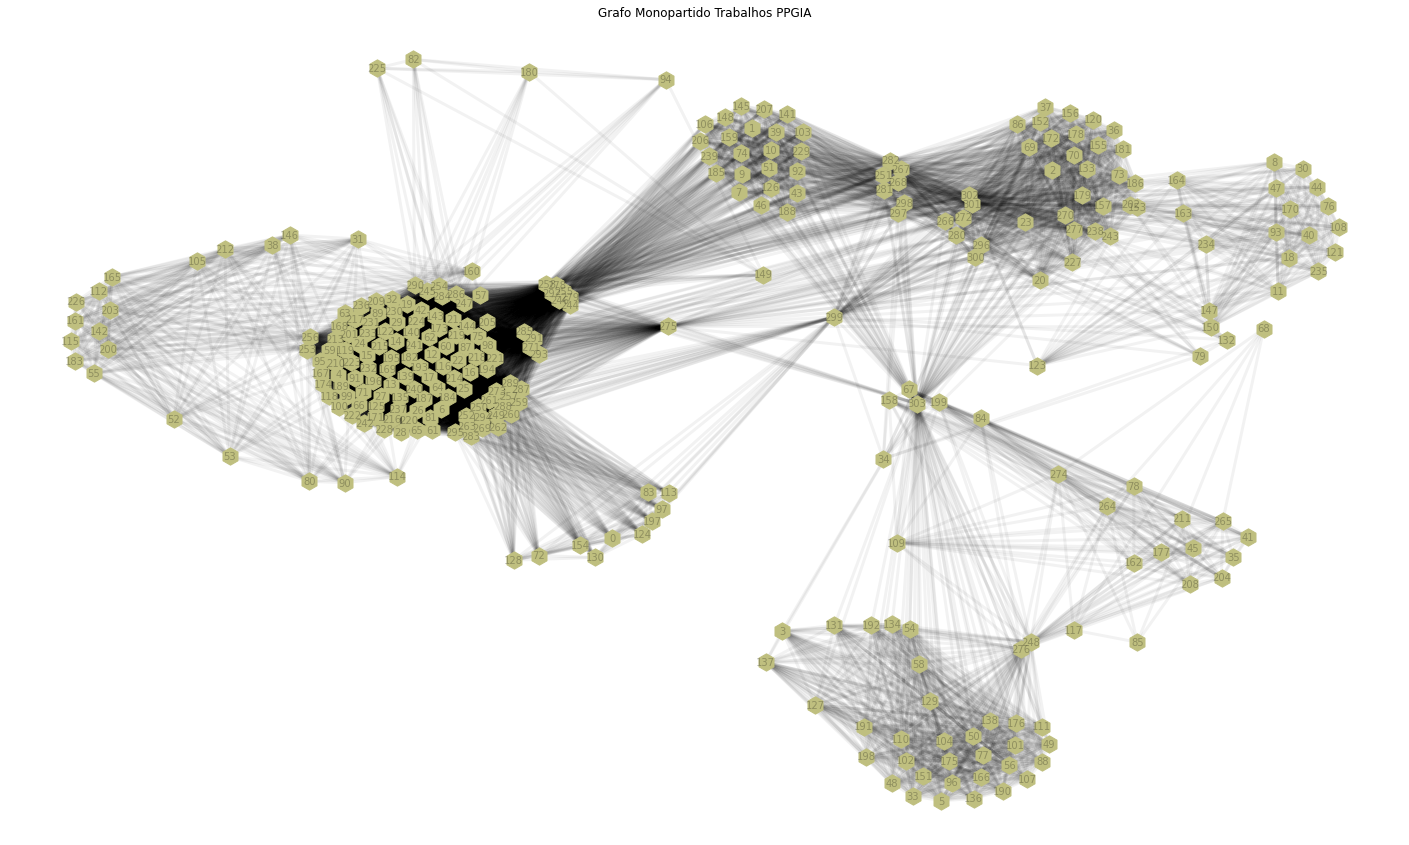

In [11]:
#@title
# Create co-affiliation network
H = bipartite.projected_graph(B, artigos)
# Create figure
plt.figure(figsize=(25,15))
plt.title('Grafo Monopartido Trabalhos PPGIA')
# Calculate layout
pos = nx.spring_layout(H, k=0.5)
# Draw edges, nodes, and labels
nx.draw_networkx_edges(H, pos, width=3, alpha=0.05)
nx.draw_networkx_nodes(H, pos, node_color="#bfbf7f", node_shape="h", node_size=300)
nx.draw_networkx_labels(H, pos, alpha=.25, font_size=10)
plt.savefig(local + 'GRAFO_P3b-3.png', dpi=150)

## Identifica os autores com maior colaboração com outros autores.

In [12]:
# Identifica os autores com maior colaboração com outros autores.
full_name_G = nx.get_node_attributes(G, "name")
# [(x, G.degree[x]) for x in sorted(autores, key=lambda x:G.degree[x], reverse=True)]
[(f'node {x}', full_name_G[x], G.degree[x]) for x in sorted(autores, key=lambda x:G.degree[x], reverse=True)]

[('node 315', 'Placido Rogerio Pinheiro', 6),
 ('node 314', 'Joao Jose Vasco Peixoto Furtado', 6),
 ('node 313', 'Maria Elizabeth Sucupira Furtado', 5),
 ('node 307', 'Vladia Celia Monteiro Pinheiro', 4),
 ('node 312', 'Maria Andreia Formico Rodrigues', 3),
 ('node 309', 'Raimir Holanda Filho', 3),
 ('node 311', 'Adriano Bessa Albuquerque', 3),
 ('node 305', 'Tarcisio Haroldo Cavalcante Pequeno', 3),
 ('node 308', 'Nabor das Chagas Mendonça', 2),
 ('node 310', 'Joao Batista Furlan Duarte', 1),
 ('node 304', 'Americo Tadeu Falcone Sampaio', 1),
 ('node 306', 'Napoleao Vieira Nepomuceno', 1)]

## Identificar os autores com maior quantidade de artigos compartilhados.

In [13]:
# Identifica os autores com maior quantidade de artigos compartilhados.

weight = nx.get_edge_attributes(G,'weight')
weight_sorted = sorted(weight.items(), key=lambda item: item[1], reverse=True)

# Normalização da ponderação para fins de comparação
# factor=1.0/sum(weight.values())
# normalised_weight = {k: v*factor for k, v in weight.items() }
# normalised_weight

for (k1,k2) in weight_sorted:
    print(f'({k1} ({full_name_G[k1[0]]} - {full_name_G[k1[1]]}): {round(k2,4)}')

((315, 311) (Placido Rogerio Pinheiro - Adriano Bessa Albuquerque): 17
((313, 314) (Maria Elizabeth Sucupira Furtado - Joao Jose Vasco Peixoto Furtado): 10
((314, 307) (Joao Jose Vasco Peixoto Furtado - Vladia Celia Monteiro Pinheiro): 8
((315, 313) (Placido Rogerio Pinheiro - Maria Elizabeth Sucupira Furtado): 7
((315, 306) (Placido Rogerio Pinheiro - Napoleao Vieira Nepomuceno): 6
((314, 305) (Joao Jose Vasco Peixoto Furtado - Tarcisio Haroldo Cavalcante Pequeno): 5
((315, 305) (Placido Rogerio Pinheiro - Tarcisio Haroldo Cavalcante Pequeno): 4
((308, 304) (Nabor das Chagas Mendonça - Americo Tadeu Falcone Sampaio): 3
((315, 310) (Placido Rogerio Pinheiro - Joao Batista Furlan Duarte): 2
((313, 307) (Maria Elizabeth Sucupira Furtado - Vladia Celia Monteiro Pinheiro): 2
((313, 309) (Maria Elizabeth Sucupira Furtado - Raimir Holanda Filho): 2
((314, 309) (Joao Jose Vasco Peixoto Furtado - Raimir Holanda Filho): 2
((312, 308) (Maria Andreia Formico Rodrigues - Nabor das Chagas Mendonça)

## Gerar um gráfico com a Frequência x Valor Link

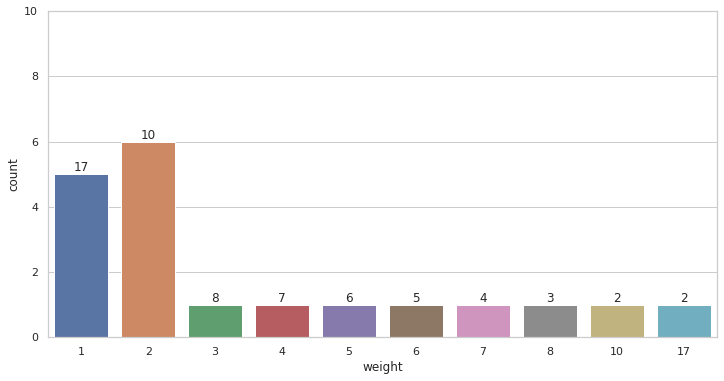

In [14]:
#@title
# Gera datraframe de arestas e valor de link
import pandas as pd
df = pd.DataFrame(weight_sorted, columns=['nodes','weight'])
df['name'] = f'{full_name_G[k1[0]]}, {full_name_G[k1[1]]}'

# Plota a contagem dos links em cada faixa de valor.
import seaborn as sns
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
ax = sns.countplot(x="weight", data=df)
ax.set_ylim(0,10)

rects = ax.patches
labels = df.weight
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')

## Calcular as seguintes propriedades da rede:

In [15]:
# Densidade
print('Densidade:', round(nx.density(G),4))

# Nós isolados
print('Nós isolados:', list(nx.isolates(G)))

# Diâmetro
print('Diâmetro:', nx.diameter(G))

# Distância média entre nós
print('Distância média entre nós:', round(nx.average_shortest_path_length(G),4))

# Coef. Clustering médio
print('Coef. Clustering médio:', round(nx.average_clustering(G),4))

# Professores altamente conectados (clique máximo)
cliques = list(nx.find_cliques(G))
max_clique = max(cliques, key=len)
print(f'Professores altamente conectados: {len(max_clique)} {[full_name_G[d] for d in max_clique]}')

# Professor que conecta diversas áreas de interesse e que sua remoção particiona a rede.
cut = nx.minimum_node_cut(G)
cut_node = [e for e in cut]
print(f'Professor de corte: {full_name_G[cut_node[0]]}')

Densidade: 0.2879
Nós isolados: []
Diâmetro: 5
Distância média entre nós: 2.2121
Coef. Clustering médio: 0.2472
Professores altamente conectados: 3 ['Joao Jose Vasco Peixoto Furtado', 'Maria Andreia Formico Rodrigues', 'Maria Elizabeth Sucupira Furtado']
Professor de corte: Placido Rogerio Pinheiro


## Aplicar diferentes cortes e analisar

### Corte 1: Isolar o clique máximo

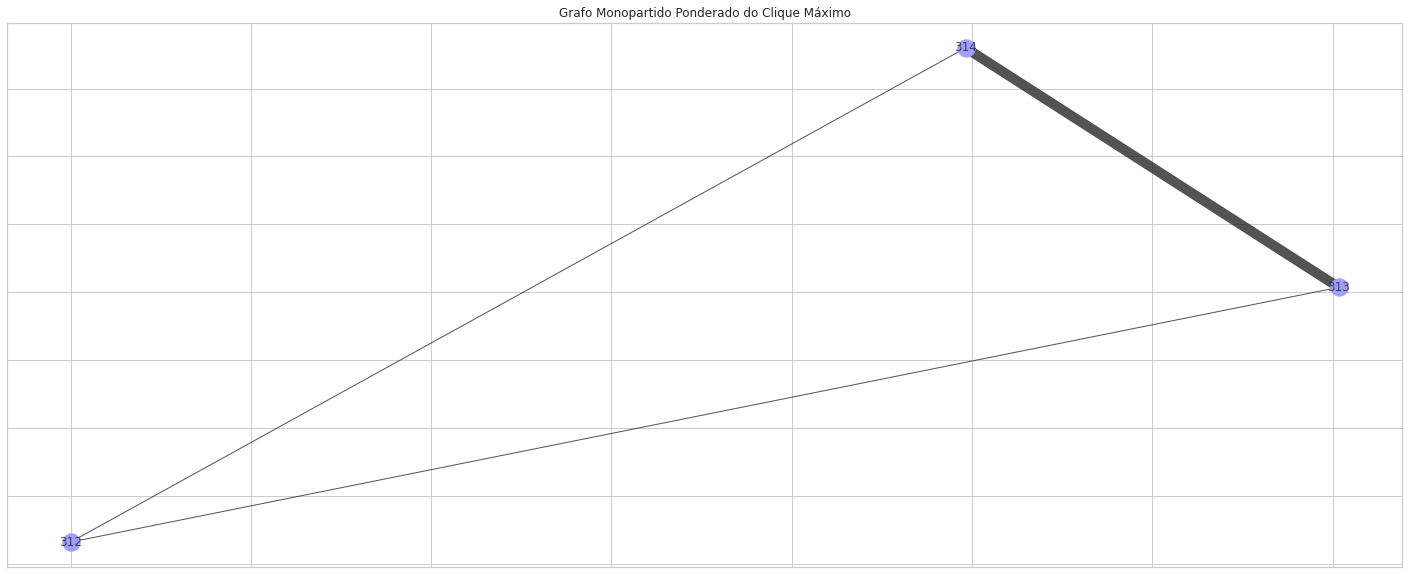

In [16]:
#@title
# Create max_clique network
G_maxclique = nx.subgraph(G, max_clique)
# Create figure
plt.figure(figsize=(25,10))
plt.title('Grafo Monopartido Ponderado do Clique Máximo')
# Get weights
weight = [G_maxclique.edges[e]['weight'] for e in G_maxclique.edges]
# Calculate layout
pos_maxclique = nx.spring_layout(G_maxclique, weight='weight', k=0.5)
# Draw edges, nodes, and labels
nx.draw_networkx_edges(G_maxclique, pos_maxclique, width=weight, alpha=0.75)
nx.draw_networkx_nodes(G_maxclique, pos_maxclique, node_color="#9f9fff", node_size=300)
nx.draw_networkx_labels(G_maxclique, pos_maxclique, alpha=.75)
plt.savefig(local + 'GRAFO_P3b-5.png', dpi=150)

In [17]:
# Identifica os nós da rede
full_name_M = nx.get_node_attributes(G_maxclique, "name")
[(x,full_name_M[x]) for x in G_maxclique.nodes]

[(312, 'Maria Andreia Formico Rodrigues'),
 (313, 'Maria Elizabeth Sucupira Furtado'),
 (314, 'Joao Jose Vasco Peixoto Furtado')]

In [18]:
# Densidade
print('Densidade:', round(nx.density(G_maxclique),4))

# Nós isolados
nodes_iso = list(nx.isolates(G_maxclique))
print(f'Nós isolados: {nx.number_of_isolates(G_maxclique)}')
[print((f'node {x}',G_maxclique.nodes[x]['name'])) for x in nodes_iso]

# Verificação de Conectividade, Diâmetro e Distância entre nós
if nx.is_connected(G_maxclique) == True:
    print('Diâmetro:', nx.diameter(G_maxclique))
    print('Distância média entre nós:', round(nx.average_shortest_path_length(G_maxclique),4))

# Coef. Clustering médio
print('Coef. Clustering médio:', round(nx.average_clustering(G_maxclique),4))

Densidade: 1.0
Nós isolados: 0
Diâmetro: 1
Distância média entre nós: 1.0
Coef. Clustering médio: 1.0


### Corte 2: Isolamento por grau mínimo

In [19]:
def filter_node(n1):
    return G.degree[n1] >= 5

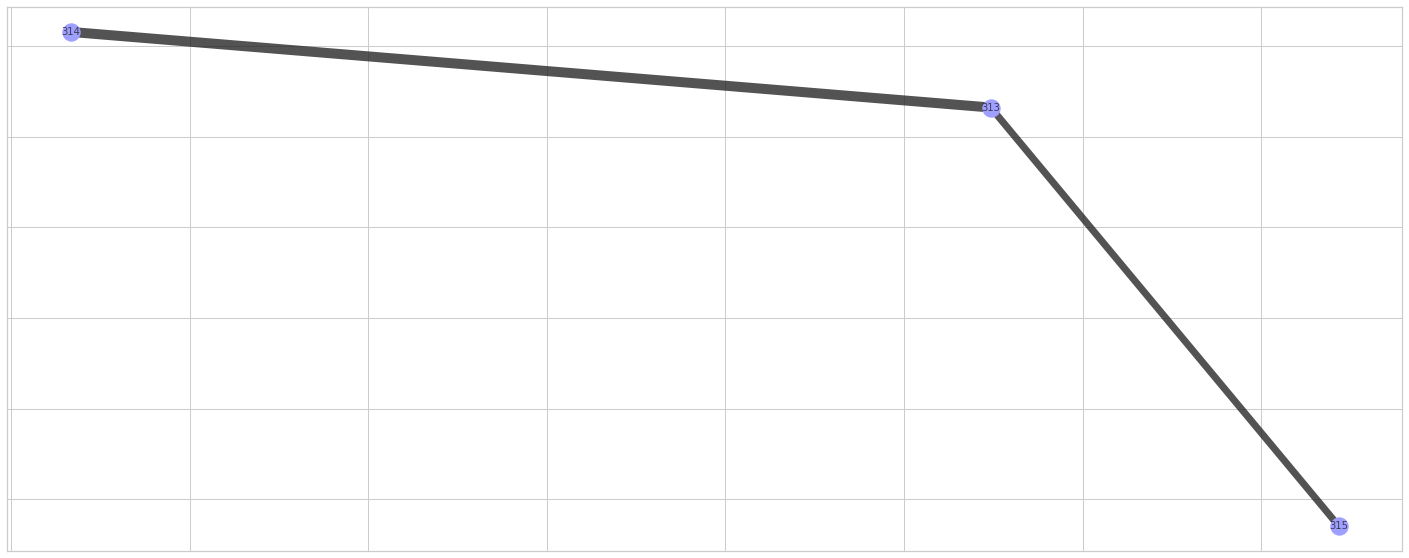

In [20]:
#@title
# Gerar grafo K3
K5 = nx.subgraph_view(G, filter_node=filter_node)
# Create figure
plt.figure(figsize=(25,10))
# Get weights
weight = [K5.edges[e]['weight'] for e in K5.edges]
# Calculate layout
pos = nx.spring_layout(G, weight='weight', k=0.5)
# Draw edges, nodes, and labels
nx.draw_networkx_edges(K5, pos, width=weight, alpha=0.75)
nx.draw_networkx_nodes(K5, pos, node_color="#9f9fff", node_size=300)
nx.draw_networkx_labels(K5, pos, alpha=.75, font_size=10)
plt.savefig(local + 'GRAFO_P3-7.png', dpi=150)

In [21]:
# Identifica os nós da rede
full_name_K = nx.get_node_attributes(K5, "name")
[(x,full_name_K[x]) for x in K5.nodes]

[(315, 'Placido Rogerio Pinheiro'),
 (313, 'Maria Elizabeth Sucupira Furtado'),
 (314, 'Joao Jose Vasco Peixoto Furtado')]

In [22]:
# Densidade
print('Densidade:', round(nx.density(K5),4))

# Nós isolados
nodes_iso = list(nx.isolates(K5))
print(f'Nós isolados: {nx.number_of_isolates(K5)}')
[print((f'node {x}',K5.nodes[x]['name'])) for x in nodes_iso]

# Verificação de Conectividade, Diâmetro e Distância entre nós
if nx.is_connected(K5) == True:
    print('Diâmetro:', nx.diameter(K5))
    print('Distância média entre nós:', round(nx.average_shortest_path_length(K5),4))

# Coef. Clustering médio
print('Coef. Clustering médio:', round(nx.average_clustering(K5),4))

Densidade: 0.6667
Nós isolados: 0
Diâmetro: 2
Distância média entre nós: 1.3333
Coef. Clustering médio: 0.0


### Corte 3: Remoção do professor Placido Rogerio Pinheiro (nó 315)

Como o nó 315 (Placido Rogerio Pinheiro) foi detectado como a única ponte entre demais professores, o corte representará a dissociação da rede e verificação de agrupamentos de interesse. 

In [23]:
#@title
# # Deepcopy da grafo G
G1 = copy.deepcopy(G)

# # Remoção do nó 315 da rede
G1.remove_node(315)

# Lista de autores com a remoção do nó 315
node = 315
if node in autores:
    autores.remove(node)

# # Remoção do nó 315 da lista de autores
[(f'node {x}', G1.nodes[x]['name']) for x in autores]

[('node 313', 'Maria Elizabeth Sucupira Furtado'),
 ('node 314', 'Joao Jose Vasco Peixoto Furtado'),
 ('node 312', 'Maria Andreia Formico Rodrigues'),
 ('node 308', 'Nabor das Chagas Mendonça'),
 ('node 309', 'Raimir Holanda Filho'),
 ('node 310', 'Joao Batista Furlan Duarte'),
 ('node 307', 'Vladia Celia Monteiro Pinheiro'),
 ('node 304', 'Americo Tadeu Falcone Sampaio'),
 ('node 311', 'Adriano Bessa Albuquerque'),
 ('node 306', 'Napoleao Vieira Nepomuceno'),
 ('node 305', 'Tarcisio Haroldo Cavalcante Pequeno')]

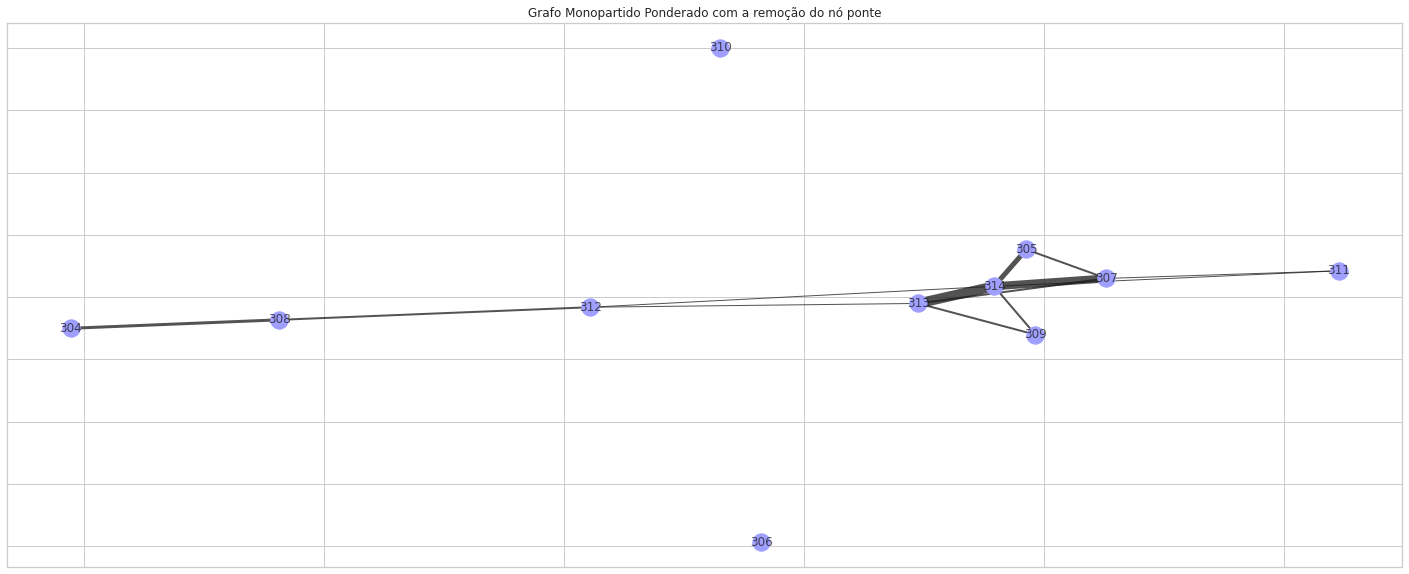

In [24]:
# Create figure
plt.figure(figsize=(25,10))
plt.title('Grafo Monopartido Ponderado com a remoção do nó ponte')
# Get weights
weight = [G1.edges[e]['weight'] for e in G1.edges]
# Calculate layout
pos = nx.spring_layout(G1, weight='weight', k=0.5)
# Draw edges, nodes, and labels
colors = range(20)
nx.draw_networkx_edges(G1, pos, width=weight, alpha=0.75)
nx.draw_networkx_nodes(G1, pos, node_color="#9f9fff", node_size=300)
nx.draw_networkx_labels(G1, pos, alpha=.75)
plt.savefig(local + 'GRAFO_P3b-4.png', dpi=150)

In [25]:
# Identifica os nós da rede
full_name_P = nx.get_node_attributes(G1, "name")
[(x,full_name_P[x]) for x in G1.nodes]

[(313, 'Maria Elizabeth Sucupira Furtado'),
 (314, 'Joao Jose Vasco Peixoto Furtado'),
 (312, 'Maria Andreia Formico Rodrigues'),
 (308, 'Nabor das Chagas Mendonça'),
 (309, 'Raimir Holanda Filho'),
 (310, 'Joao Batista Furlan Duarte'),
 (307, 'Vladia Celia Monteiro Pinheiro'),
 (304, 'Americo Tadeu Falcone Sampaio'),
 (311, 'Adriano Bessa Albuquerque'),
 (306, 'Napoleao Vieira Nepomuceno'),
 (305, 'Tarcisio Haroldo Cavalcante Pequeno')]

In [26]:
# Densidade
print('Densidade:', round(nx.density(G1),4))

# Nós isolados
print('Nós isolados:', list(nx.isolates(G1)))

# Verificação de Conectividade, Diâmetro e Distância entre nós

if nx.is_connected(G1) == True:
    print('Diâmetro:', nx.diameter(G1))
    print('Distância média entre nós:', round(nx.average_shortest_path_length(G1),4))
else:
    print(f'Número de nós isolados: {nx.number_of_isolates(G1)}')

# Coef. Clustering médio
print('Coef. Clustering médio:', round(nx.average_clustering(G1),4))

Densidade: 0.2364
Nós isolados: [310, 306]
Número de nós isolados: 2
Coef. Clustering médio: 0.4242
